In [2]:
import pandas as pd
from scipy.optimize import minimize, Bounds
import matplotlib.pyplot as plt
import numpy as np
import model.integrated_model as model

# The basic concept of a integrated watershed hydrology model

Here is a basic diagram of a integrated watershed hydrology model:

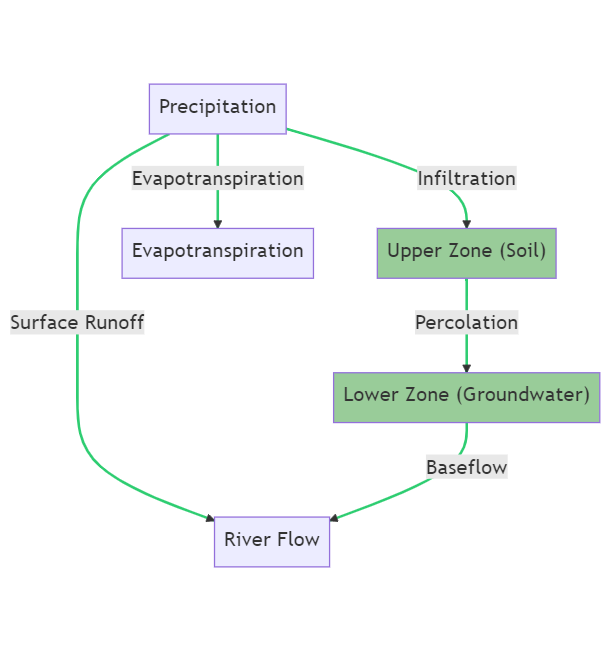

In this model:

1. Precipitation is the input to the system. It can either infiltrate into the soil (Upper Zone) or become surface runoff.

2. The Upper Zone represents the soil layer. Water in this zone can either percolate down to the Lower Zone or contribute to the surface runoff.

3. The Lower Zone represents the groundwater layer. Water in this zone contributes to the baseflow, which is the part of the river flow that is sustained by groundwater.

4. Evapotranspiration represents the sum of evaporation and plant transpiration from the Earth's land surface to the atmosphere.

5. The River Flow is the final output of the system, representing the flow of water in the river. It is the sum of the surface runoff and the baseflow.

6. Infiltration: It's the process of water entering the soil from the surface. The most influential factor is the soil type, as different soils have different capacities to absorb water.

7. Percolation: This is the downward movement of water within the soil layer. The soil's permeability, which is determined by its physical properties, is the most influential factor.

8. Surface Runoff: This is water flowing over the land when soil is saturated. The intensity and duration of rainfall are the most influential factors, as heavy or prolonged rain can quickly saturate the soil.

9. Baseflow: This is the part of streamflow that comes from natural storage like groundwater. The level of groundwater is the most influential factor, as it determines how much water is available to contribute to baseflow.

Remember, these are simplified explanations and each process is influenced by a complex interplay of factors.

This is a simplified model and real-world hydrological systems can be much more complex. However, the tank model provides a useful framework for understanding and simulating the basic processes involved in the hydrological cycle.

## （Direct runoff and baseflow）and (Surface runoff and baseflow)

### Q1: As I know, the discharge is equal to direct runoff and baseflow. But in your diagram, it seems that surface runoff plus baseflow equal to river flow

 In the context of hydrology and the tank model, the terms "discharge" and "river flow" are often used interchangeably to refer to the total amount of water flowing in a river or stream at a given location and time. This total flow is indeed composed of both direct runoff (or surface runoff) and baseflow.

Surface Runoff (Direct Runoff): This is the portion of precipitation that rapidly flows over the land surface into the stream channel. It's often associated with high-intensity rainfall and is more likely to cause flooding problems.

Baseflow: This is the portion of streamflow that's sustained between precipitation events, fed to streams by delayed pathways. It's often a significant contributor to streamflow in non-rainy periods, and it's largely influenced by groundwater levels.

So, in the integrated watershed hydrology model diagram, the "River Flow" or "Discharge" is indeed the sum of the surface runoff and the baseflow. This total flow is what's observed at a stream gauge station as the total river discharge. 

### Q2: Can you see the direct runoff as the surface runoff

In hydrology, the terms "direct runoff" and "surface runoff" are often used interchangeably. Both terms refer to the portion of precipitation that flows over the land surface to the stream channel shortly after a rainfall event.

However, it's important to note that the term "direct runoff" can sometimes be used in a broader sense to include not only surface runoff, but also other components of runoff that reach the stream quickly after a rainfall event, such as interflow (the portion of rainfall that infiltrates into the soil and moves laterally to the stream through the upper soil layers).

In the context of the integrated watershed hydrology model, we typically consider only surface runoff and baseflow (groundwater contribution), and we often use the term "direct runoff" to refer specifically to surface runoff.

### Q3: The relationship between upper zone storage and surface runoff

The upper zone storage represents the amount of water stored in the soil layer, not all of which will necessarily become runoff.

In a more detailed model, the surface runoff would be a portion of the water that enters the upper zone (from precipitation) but does not infiltrate into the soil and instead flows over the land surface. The amount of surface runoff is influenced by several factors, including the intensity and duration of precipitation, the soil type, land cover, and the initial moisture content of the soil.

The equation should be corrected to:

$$ Runoff = SurfaceRunoff + Baseflow $$

Where:

Surface runoff is the portion of precipitation that flows over the land surface to the river.
Baseflow is the portion of the river flow that is sustained by groundwater.

# Data

In [7]:
impervious_area 

,Predicted_impervious_area
Year,
1989,0.01
1990,0.01
1991,0.02
1992,0.03
1993,0.05
...,...
2046,13.80
2047,13.80
2048,13.80


In [10]:
# Load data
fengqiao = pd.read_csv('../data/intermediate/fengqiao_processed.csv', index_col=0, parse_dates=True)
mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0, parse_dates=True)
impervious_area = pd.read_csv('../data/intermediate/Urban_Impervious_Area.csv', index_col=0)

# Get values
precipitation = fengqiao['precipitation'].values
discharge = fengqiao['discharge'].values
water_level = fengqiao['water_level'].values
et = mete['ETo_PM'].values

# Parameters
infiltration_rate = 0.005  # Infiltration rate
percolation_rate = 0.005  # Percolation rate
baseflow_rate = 0.005  # Baseflow rate


# Initialize upper and lower zone storage
upper_zone_storage = 100
lower_zone_storage = 100

# Area
Area = 3690

params = [infiltration_rate, percolation_rate, baseflow_rate, upper_zone_storage, lower_zone_storage]

# Integrated watershed hydrology model

In [4]:
runoff, surface_runoff, baseflow = model.integrated_model(params, precipitation, et, Area)

## Considering the Impervious Area percent

As for adding the Impermeability Expansion percent, this could be incorporated into the model by adjusting the infiltration rate. The more impervious the area, the less water can infiltrate into the soil, and the more water becomes surface runoff.

Here's how you could modify the infiltration calculation to take into account the Impermeability Expansion percent:

In [5]:
runoff, surface_runoff, baseflow = model.integrated_model(params, precipitation, et, Area, impervious_area=impervious_area)

## Calibrate the model

To calibrate the model parameters with the discharge values, you can use an optimization method such as the Least Squares method. The goal is to minimize the difference between the observed discharge values and the runoff calculated by the model.

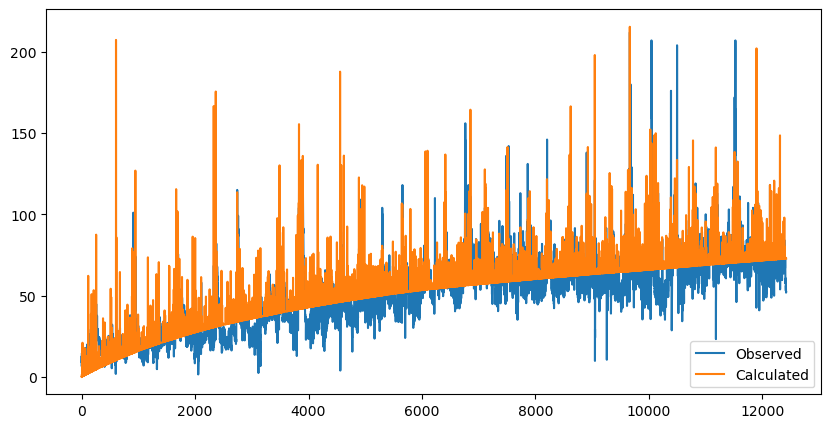

In [12]:
Area = 86.4
# Define a function to calculate the sum of squared differences between observed and calculated runoff
def objective(params):
    runoff, _, _= model.integrated_model(params, precipitation, et,Area)
    difference = np.array(discharge) - runoff
    sum_of_squares = np.sum(difference**2)
    return sum_of_squares

# Define a function to calculate the runoff
def calculate_runoff(params):
    runoff,_,_ = model.integrated_model(params, precipitation, et, Area)
    return runoff

# Initial guess for the parameters
# params = [infiltration_rate, percolation_rate, baseflow_rate, upper_zone_storage, lower_zone_storage]
initial_guess = [0.005, 0.005, 0.005,100,100]

# Define bounds for the parameters and storage values
bounds = Bounds([0, 0, 0, 0 ,0], [1, 1,1, 1000, 1000]) # type: ignore

# Run the optimization with constraints and a different method
result = minimize(objective, initial_guess, method='Nelder-Mead', bounds=bounds)

# Evaluate the model with the optimal parameters
calculated_runoff = calculate_runoff(result.x)

# Plot the observed and calculated runoff
plt.figure(figsize=(10,5))
plt.plot(range(len(discharge)), discharge, label='Observed')
plt.plot(range(len(calculated_runoff)), calculated_runoff, label='Calculated')
plt.legend()
plt.show()

In [9]:
# Extract the optimal parameters
optimal_params = result.x

# Print the optimal parameters
print("Optimal parameters:")
print("Infiltration rate: ", optimal_params[0])
print("Percolation rate: ", optimal_params[1])
print("Baseflow rate: ", optimal_params[2])
print("Upper zone storage: ", optimal_params[3])
print("Lower zone storage: ", optimal_params[4])

Optimal parameters:
Infiltration rate:  0.0044493533287026255
Percolation rate:  0.0015114617133019205
Baseflow rate:  0.018787726309103157
Upper zone storage:  640.1599637595345
Lower zone storage:  0.0


In [9]:
fengqiao['calculate_runoff'] = calculated_runoff 
fengqiao.to_csv('../data/intermediate/fengqiao_integrated_model.csv')

In [8]:
optimal_params

array([4.44935333e-03, 1.51146171e-03, 1.87877263e-02, 6.40159964e+02,
       0.00000000e+00])

## Error

### Root Mean Squared Error (RMSE)

This is the square root of the average of the squared differences between the predicted and actual values. It's a popular choice because it penalizes large errors more due to the squaring operation.

In [8]:
# Calculate the Root Mean Squared Error
rmse = np.sqrt(np.mean((np.array(discharge) - np.array(calculated_runoff))**2))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 15.54638528259419


### Mean Absolute Error (MAE)

This is the average of the absolute differences between the predicted and actual values. It's less sensitive to outliers compared to RMSE.

In [9]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(np.array(discharge), np.array(calculated_runoff))
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 10.757616046578608


### R-squared (R²)

This is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. It provides a measure of how well future samples are likely to be predicted by the model. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

In [7]:
from sklearn.metrics import r2_score
r2 = r2_score(np.array(discharge), calculated_runoff)
print("R-squared (R²):", r2)

R-squared (R²): 0.5314943365056866


### Mean Squared Logarithmic Error (MSLE)

This is a variation of MSE, but the targets are transformed by taking the logarithm. It's less sensitive to outliers and is mainly used when the target variable is expected to grow exponentially.

In [11]:
from sklearn.metrics import mean_squared_log_error
msle = mean_squared_log_error(np.array(discharge), calculated_runoff)
print("Mean Squared Logarithmic Error (MSLE):", msle)

Mean Squared Logarithmic Error (MSLE): 0.15792123341015982
